## Fetch the Data and Visualize Data

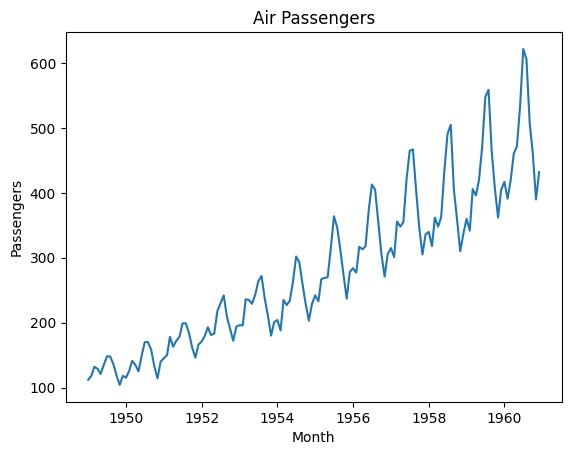

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('data-sets/air_passengers.csv')

# Convert the 'Month' column to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Set 'Month' as the index
df.set_index('Month', inplace=True)

df['Passengers'] = df
plt.plot(df)
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.title('Air Passengers')
plt.show()

## Determine p,d,q,s parameters and clear trend and seasonality

In [12]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# d = # of differencing

# First, test for stationarity

result = adfuller(df['Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# This part is wrong we should take 2nd order differencing or more.
# Change the if loop
# If p-value > 0.05, the series is non-stationary, we need to take differences
if result[1] > 0.05:
    df['diff_1'] = df['Passengers'].diff()
    result = adfuller(df['diff_1'].dropna())
    print('ADF Statistic after 1st diff: %f' % result[0])
    print('p-value after 1st diff: %f' % result[1])
    d = 1
else:
    d = 0

# s = seasonality component
s = 12
df 
# Then, decompose the series to find the seasonal component
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='additive', period=s)

train_size = int(len(df) * 0.8)
test_size = int(len(df) * 0.2)

df['trend'] = decomposition.trend

df['seasonal'] = decomposition.seasonal

df['normalized_residual'] = decomposition.resid
df.dropna(inplace=True)  # Drop rows with NaN values
# Detrend and deseasonalize by dividing by the trend and seasonal components
df['detrended'] = df['Passengers'] / df['trend']
df['deseasonalized'] = df['detrended'] / df['seasonal']


ADF Statistic: 0.815369
p-value: 0.991880
ADF Statistic after 1st diff: -2.829267
p-value after 1st diff: 0.054213


In [13]:
# Normalized residual
#df['normalized_residual']=(df['residual'] - df['residual'].min()) / (df['residual'].max() - df['residual'].min())
#plt.plot(df['normalized_residual'])

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# p = AR component
p = 2

for i in range(1, p+1):
    df[f'lag_{i}'] = df['normalized_residual'].shift(i)


# q = MA component
q = 1

df['rolling_mean'] = df['normalized_residual'].rolling(window=q).mean()

df.dropna(inplace=True)  # Drop rows with NaN values

df

,Passengers,diff_1,trend,seasonal,normalized_residual,detrended,deseasonalized,lag_1,lag_2,rolling_mean
Month,,,,,,,,,,
1949-09-01,136,-12.0,127.958333,16.520202,-8.478535,1.062846,0.064336,-42.073232,-42.622475,-8.478535
1949-10-01,119,-17.0,128.583333,-20.642677,11.059343,0.925470,-0.044833,-8.478535,-42.073232,11.059343
1949-11-01,104,-15.0,129.000000,-53.593434,28.593434,0.806202,-0.015043,11.059343,-8.478535,28.593434
1949-12-01,118,14.0,129.750000,-28.619949,16.869949,0.909441,-0.031776,28.593434,11.059343,16.869949
1950-01-01,115,-3.0,131.250000,-24.748737,8.498737,0.876190,-0.035403,16.869949,28.593434,8.498737
...,...,...,...,...,...,...,...,...,...,...
1960-02-01,391,-26.0,461.375000,-36.188131,-34.186869,0.847467,-0.023418,-14.584596,-17.005051,-34.186869
1960-03-01,419,28.0,465.208333,-2.241162,-43.967172,0.900672,-0.401877,-34.186869,-14.584596,-43.967172
1960-04-01,461,42.0,469.333333,-8.036616,-0.296717,0.982244,-0.122221,-43.967172,-34.186869,-0.296717


In [15]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df[['lag_1', 'lag_2', 'rolling_mean']]
y = df['normalized_residual']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



## Bayesian Oprimization for Hyperparameter Tuning

In [16]:
from sklearn.model_selection import KFold, GridSearchCV
from skopt.plots import plot_objective, plot_histogram
import skopt
from sklearn.linear_model import LinearRegression
import numpy as np

# Decleartions for deprecated functions in numpy
np.float = float    
np.int = int    
np.object = object    
np.bool = bool    

# Define hyperparameters for bayesian optimization
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
    }


kFold = KFold(n_splits=5, shuffle=True, random_state=42)

model = LinearRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= kFold, n_jobs=-1, 
                             scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = grid_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['fit_intercept'] = cv_results_df['params'].apply(lambda x: x['fit_intercept'])
cv_results_df['copy_X'] = cv_results_df['params'].apply(lambda x: x['copy_X'])


print(cv_results_df[['mean_test_score', 'fit_intercept', 'copy_X']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

best_model = grid_search.best_estimator_

   mean_test_score  fit_intercept  copy_X
0    -7.603491e-16           True    True
1    -7.626907e-16          False    True
2    -7.603491e-16           True   False
3    -7.626907e-16          False   False
Best hyperparameters: {'copy_X': True, 'fit_intercept': True}


26


,normalized_residual
Month,
1958-05-01,-13.202020
1958-06-01,18.638889
1958-07-01,45.335859
1958-08-01,58.510101
1958-09-01,0.979798
1958-10-01,-10.690657
1958-11-01,-31.114899
1958-12-01,-33.005051
1959-01-01,-17.792929


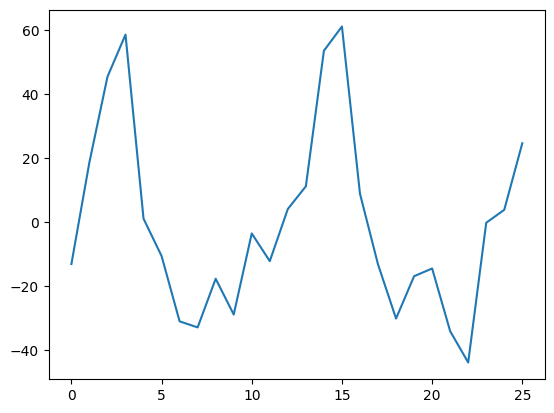

In [17]:

best_model.fit(X_train, y_train)

# Predict residuals
residuals_predicted = best_model.predict(X_test)
plt.plot(residuals_predicted)
print(len(residuals_predicted))
test_df = pd.DataFrame(y_test)
test_df

In [18]:
df['trend_train'] = df['trend'][:train_size]
df['trend_test'] = df['trend'][train_size:]
df['seasonal_train'] = df['seasonal'][:train_size]
df['seasonal_test'] = df['seasonal'][train_size:]
print(df['seasonal'][train_size:].shape)
print(df['seasonal_test'].shape)

(15,)
(130,)


(26,)
(130,)
(130,)
DatetimeIndex(['1958-05-01', '1958-06-01', '1958-07-01', '1958-08-01',
               '1958-09-01', '1958-10-01', '1958-11-01', '1958-12-01',
               '1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
               '1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01'],
              dtype='datetime64[ns]', name='Month', freq=None)


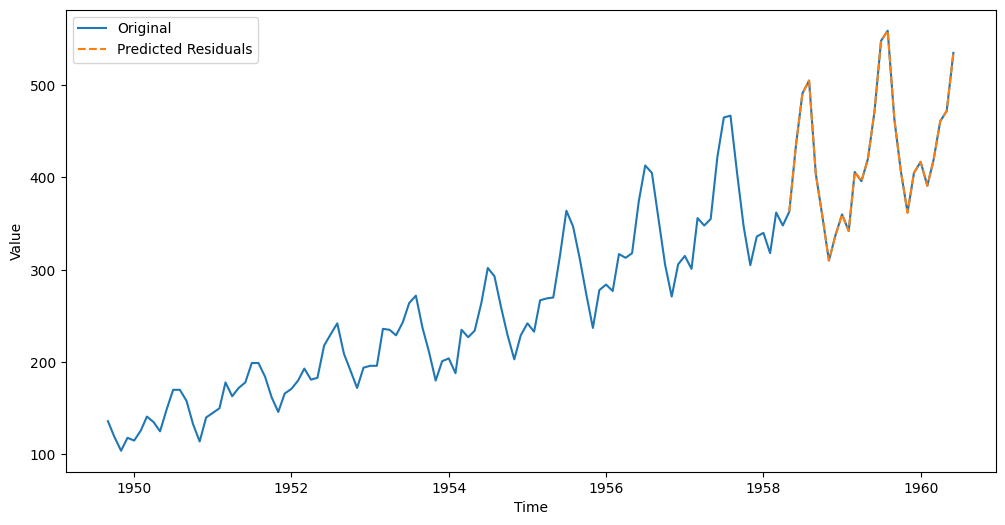

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for the predicted residuals
residuals_predicted_df = pd.DataFrame(residuals_predicted, index=X_test.index, columns=['predicted_residuals'])

# Denormalize data
#residuals_predicted_df = (residuals_predicted_df - residuals_predicted_df.min()) / (residuals_predicted_df.max() - residuals_predicted_df.min())

print(residuals_predicted_df['predicted_residuals'].shape)
print(df['seasonal_test'].shape)
print(df['trend_test'].shape)
# Add trend and seasonality back to the perdicted residual
residuals_predicted_df['reconstructed'] = df['trend'] + df['seasonal'] + residuals_predicted_df['predicted_residuals']


# Plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot the latter part of the original time series
ax.plot(df.loc[df.index, 'Passengers'], label='Original')

# Plot the predicted residuals
ax.plot(residuals_predicted_df['reconstructed'], label='Predicted Residuals', linestyle='--')

print(residuals_predicted_df['reconstructed'].index)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import math

# Assuming 'Passengers' is your original data and 'reconstructed' is your predicted data
mse = mean_squared_error(df.loc[X_test.index, 'Passengers'], residuals_predicted_df['reconstructed'])
rmse = math.sqrt(mse)
nrmse = rmse / (df.loc[X_test.index, 'Passengers'].max() - df.loc[X_test.index, 'Passengers'].min())
r2e = r2_score(df.loc[X_test.index, 'Passengers'], residuals_predicted_df['reconstructed'])
mape = mean_absolute_percentage_error(df.loc[X_test.index, 'Passengers'], residuals_predicted_df['reconstructed'])

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("Normalized Root Mean Squared Error:", nrmse)
print("R Squared Error: ", r2e)
print("MAPE", mape)

Mean Squared Error:  3.72827800129069e-28
Root Mean Squared Error:  1.9308749315506402e-14
Normalized Root Mean Squared Error: 7.75451779739213e-17
R Squared Error:  1.0
MAPE 1.4482160948150688e-17
